In [3]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore")

# Get Data

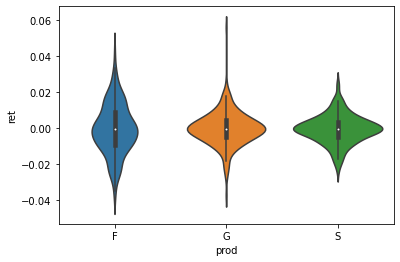

In [67]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()


# Combine Seperate DFs into one
combined_df = pd.DataFrame()
for k , v in data.items():
    # Create Returns and Directional Movement
    v["ret"] = v["close"].pct_change()
    v.dropna(axis = 0 , inplace = True)
    v["dir"] = v["ret"].apply(lambda x: 1 if x >= 0  else 0)
    v["prod"] = k
    combined_df = pd.concat([combined_df , v[["ret","dir","prod"]]] , axis = 0)
    
# Visualize Data
sns.violinplot(x='prod', y='ret', data=combined_df)

# Create Categories

x_m = combined_df[combined_df["prod"] != "S"]
idx = pd.Categorical(x_m["prod"], categories=["F","G"]).codes
groups = len(np.unique(idx))

x_m = x_m["ret"].values
y_m = combined_df[combined_df["prod"] == "S"]["ret"].values
N = len(y_m)
y_m = np.concatenate([y_m , y_m])
x_centered = x_m - x_m.mean()

# Visualize the Data relationships

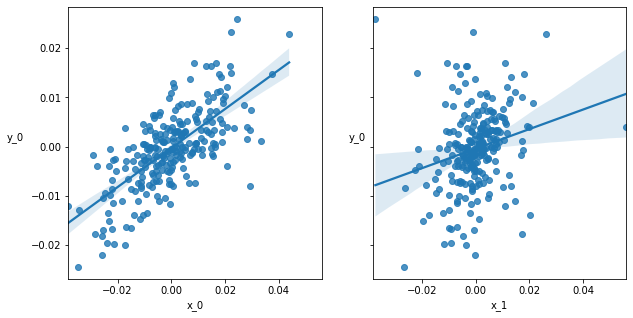

In [84]:
_, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(groups):
#     ax[i].scatter(x_m[j:k], y_m[j:k])
    sns.regplot(x=x_m[j:k], y=y_m[j:k],  ax = ax[i] );
    ax[i].set_xlabel('x_{}'.format(i))
    ax[i].set_ylabel('y_0', rotation=0, labelpad=15)
    j += N
    k += N

# Linear Regression with Groups (but no hierachical, so no pooling)

In [57]:
with pm.Model() as unpooled_model:
    intercept_ = pm.Normal('intercept_', mu=0, sd=10, shape=groups)
    slope = pm.Normal('slope', mu=0, sd=10, shape=groups)
    dof = pm.Exponential('dof', 1/30)
    sigma = pm.HalfCauchy('sigma', 5)
    
    mu = pm.Deterministic('mu', intercept_[idx] + slope[idx] * x_centered,)
    y_pred = pm.StudentT('y_pred', mu= mu, sd=sigma, nu=dof, observed=y_m)

    intercept = pm.Deterministic('intercept', intercept_ - slope * x_m.mean())

    trace_up = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, dof, slope, intercept_]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:39<00:00, 128.10draws/s]
The acceptance probability does not match the target. It is 0.8987446616511345, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9049636106539247, but should be close to 0.8. Try to increase the number of tuning steps.


mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
intercept[0] -0.000  0.000  -0.001    0.000      0.000    0.000    3968.0   
intercept[1] -0.000  0.000  -0.001    0.000      0.000    0.000    4833.0   
slope[0]      0.385  0.031   0.326    0.442      0.000    0.000    4052.0   
slope[1]      0.289  0.053   0.185    0.386      0.001    0.001    5806.0   

              ess_sd  ess_bulk  ess_tail  r_hat  
intercept[0]  2443.0    3967.0    2923.0    1.0  
intercept[1]  3451.0    4823.0    2862.0    1.0  
slope[0]      4013.0    4028.0    2586.0    1.0  
slope[1]      5529.0    5781.0    2992.0    1.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1268092d0>],
      dtype=object)

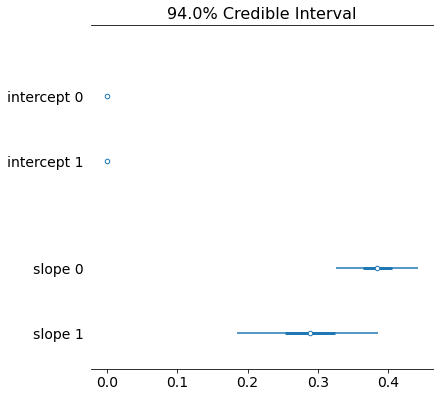

In [61]:
display(az.summary(trace_up, var_names=['intercept', 'slope']))
az.plot_forest(trace_up, var_names=['intercept', 'slope'], combined=True)

# Linear Regresion with Groups and Hierachical

In [89]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    intercept_mu_tmp = pm.Normal('intercept_mu_tmp', mu=0, sd=10)
    intercept_sigma_tmp = pm.HalfNormal('intercept_sigma_tmp', 10)
    slope_mu = pm.Normal('slope_mu', mu=0, sd=10)
    slope_sigma = pm.HalfNormal('slope_sigma', sd=10)

    # priors
    intercept_tmp = pm.Normal('intercept_tmp', mu=intercept_mu_tmp, sd=intercept_sigma_tmp, shape=groups)
    slope = pm.Normal('slope', mu=slope_mu, sd=slope_sigma, shape=groups)
    sigma = pm.HalfCauchy('sigma', 5)
    dof = pm.Exponential('dof', 1/30)

    y_pred = pm.StudentT('y_pred', mu=intercept_tmp[idx] + slope[idx] * x_centered,
                         sd=sigma, nu=dof, observed=y_m)

    intercept = pm.Deterministic('intercept', intercept_tmp - slope * x_m.mean())
    intercept_mu = pm.Deterministic('intercept_mu', intercept_mu_tmp - slope_mu * x_m.mean())
    intercept_sigma = pm.Deterministic('intercept_sd', intercept_sigma_tmp - slope_mu * x_m.mean())

    trace_hm = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [dof, sigma, slope, intercept_tmp, slope_sigma, slope_mu, intercept_sigma_tmp, intercept_mu_tmp]
Sampling 2 chains, 654 divergences: 100%|██████████| 3000/3000 [00:53<00:00, 55.99draws/s] 
There were 199 divergences after tuning. Increase `target_accept` or reparameterize.
There were 455 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.36400619826198405, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x128c8a890>],
      dtype=object)

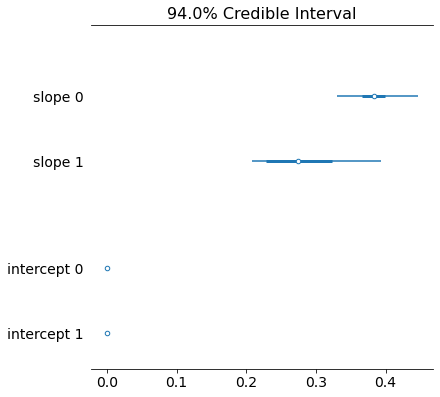

In [90]:
az.plot_forest(trace_hm, var_names=['slope', 'intercept'], combined=True)

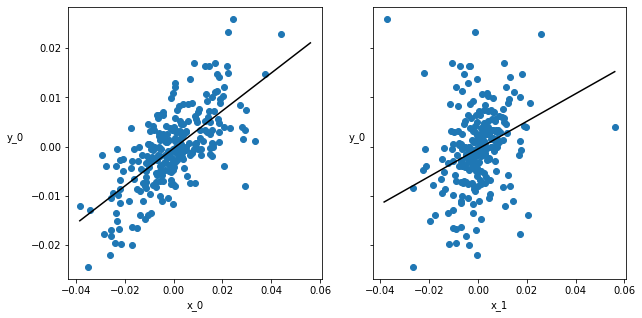

In [94]:
_, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(groups):
    ax[i].set_xlabel('x_{}'.format(i))
    ax[i].set_ylabel('y_0', rotation=0, labelpad=15)
    intercept_m = trace_hm['intercept'][:, i].mean()
    slope_m = trace_hm['slope'][:, i].mean()
    ax[i].scatter(x=x_m[j:k], y=y_m[j:k]);
    ax[i].plot(x_range, intercept_m + slope_m * x_range, c='k',
               label=f'y = {intercept_m:.2f} + {slope_m:.2f} * x')
    j += N
    k += N